<a href="https://colab.research.google.com/github/chineidu/NLP-Tutorial/blob/main/notebook/Projects/Data-mining/02-sentiments-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

```sh
!pip install transformers[torch]
!pip install datasets evaluate
!pip install sentence-transformers pinecone-client
```

## Install Dependencies

In [1]:
!pip install transformers[torch]
!pip install datasets evaluate
!pip install sentence-transformers pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 34.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=8490418987a93c81c0f958566bf2c0

In [2]:
# Built-in library
import re
import json
from typing import Any, Optional, TypeAlias, Union
import logging
import warnings

# Standard imports
import numpy as np
from pprint import pprint
import pandas as pd
import polars as pl
from rich import print
import torch

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
# %load_ext lab_black

# auto reload imports
# %load_ext autoreload
# %autoreload 2

## Load And Prepare Dataset

- I'll be using a dataset containing approx. 90k hotel reviews by customers.
- The dataset can be loaded using HuggingFace datasets.

In [3]:
from datasets import load_dataset, Dataset


PATH: str = "ashraq/hotel-reviews"
reviews_data: Dataset = load_dataset(PATH, split="train")
reviews_data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/93757 [00:00<?, ? examples/s]

Dataset({
    features: ['review_date', 'hotel_name', 'review'],
    num_rows: 93757
})

In [4]:
RANDOM_STATE: int = 123

print(reviews_data[:3])

{
    'review_date': ['8/3/2017', '8/3/2017', '8/3/2017'],
    'hotel_name': [
        'Park Plaza County Hall London',
        'Park Plaza County Hall London',
        'Park Plaza County Hall London'
    ],
    'review': [
        ' Extra bed was the worst breakfast queue was really terrible It s easy to tell people to come at a 
specific time though you have to arrange it somehow Parking is far away and hard to come back because of road 
diversions ',
        ' Just the location and view',
        ' Around the corner from the London eye and used it for a Trafalgar trip as the pickup for our tour was 
around the corner Walked down to the Borough market and took a river cruise to Greenwich Plent of eating spots 
close by as well Over the bridge was Westminster Abbey Parliament House and Big Ben and walked to Trafalgar Square 
as well also a laundry available which is very helpful '
    ]
}

In [5]:
Example: TypeAlias = dict[str, Any]

def get_text_length(example: Example) -> Example:
  """This returns the length of the review. """
  key: str = "review"
  result: Example = {"review_length": [len(x) for x in example.get(key)]}
  return result

In [6]:
reviews_data: Dataset = reviews_data.map(get_text_length, batched=True)
reviews_data

Map:   0%|          | 0/93757 [00:00<?, ? examples/s]

Dataset({
    features: ['review_date', 'hotel_name', 'review', 'review_length'],
    num_rows: 93757
})

In [7]:
# Cheeck the length of the reviews
N: int = 5
result: Example = reviews_data.sort("review_length", reverse=True)[:N]
print(result.get("review_length"))

[1966, 1959, 1943, 1937, 1937]

In [8]:
# Convert to tabular data
df: pd.DataFrame = reviews_data.to_pandas()

df_pl: pl.DataFrame = pl.from_pandas(data=df)
df_pl

review_date,hotel_name,review,review_length
str,str,str,i64
"""8/3/2017""","""Park Plaza Cou…",""" Extra bed was…",220
"""8/3/2017""","""Park Plaza Cou…",""" Just the loca…",27
"""8/3/2017""","""Park Plaza Cou…",""" Around the co…",384
"""8/2/2017""","""Park Plaza Cou…",""" I wish you ha…",33
"""8/2/2017""","""Park Plaza Cou…",""" You re always…",270
"""8/2/2017""","""Park Plaza Cou…",""" Bit of a wait…",40
"""8/2/2017""","""Park Plaza Cou…",""" The staff wer…",118
"""8/2/2017""","""Park Plaza Cou…",""" Housekeeping …",697
"""8/2/2017""","""Park Plaza Cou…",""" The location …",226


In [9]:
df_pl.describe(percentiles=[0.05, 0.10, 0.95])

describe,review_date,hotel_name,review,review_length
str,str,str,str,f64
"""count""","""93757""","""93757""","""93757""",93757.0
"""null_count""","""0""","""0""","""0""",0.0
"""mean""",null,null,null,108.006496
"""std""",null,null,null,140.482189
"""min""","""1/1/2016""","""Blakemore Hyde…",""" """,1.0
"""max""","""9/9/2016""","""Strand Palace …","""90""",1966.0
"""median""",null,null,null,64.0
"""5%""",null,null,null,9.0
"""10%""",null,null,null,15.0


```python
# Convert back to HF dataset
reviews_data_1: Dataset = Dataset.from_pandas(df=df_pl.to_pandas())
reviews_data_1
```

## Initialize Sentiment Analysis Model

- I'll be using a finetuned [RoBERTa](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=This+hotel+is+not+so+great.+It+lacks+basic+facilities.) model.

In [10]:
# Set up the labels. The model label is obtained form the model card
label2id: dict[str, Any] = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label: dict[str, Any] = {_id:_label for _label, _id in label2id.items()}

print(f"label2id: {label2id}")
print(f"id2label: {id2label}")

label2id: {'negative': 0, 'neutral': 1, 'positive': 2}

id2label: {0: 'negative', 1: 'neutral', 2: 'positive'}

In [11]:
from transformers import (AutoTokenizer,
                          AutoModelForSequenceClassification,
                          pipeline,)


MODEL_CHECKPOINT: str = "cardiffnlp/twitter-roberta-base-sentiment-latest"
TASK: str = "sentiment-analysis"

# Load the model from HuggingFace Hub
model = AutoModelForSequenceClassification.from_pretrained(MODEL_CHECKPOINT,
                                                           id2label=id2label,
                                                           label2id=label2id,)

# Load the tokenizer from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [12]:
# Check if GPU is available
device: str = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda

In [13]:
# Setup the classifier pipeline
clf = pipeline(task=TASK, model=model, device=device, tokenizer=tokenizer)

In [14]:
# Test the classifier pipeline
text: str = reviews_data[250].get("review")

print(text)

Everything was perfect especially the Italian restaurant where the food was outstanding Everyone were extremely 
nice and helpful and I mean everyone

In [15]:
clf(text)

[{'label': 'positive', 'score': 0.9884264469146729}]

<br><hr>

## Initialize Retriever

- **Retriever**:
  - In NLP, a `retriever` is a component that identifies and retrieves relevant documents or passages from a large corpus of text.

- Applications:
  - Question answering
  - Information retrieval
  - Text summarization

- `Sentence-transformer` model will be used as the `retriever`.

- I'll be using [all-MiniLM-L6-v2](sentence-transformers/all-MiniLM-L6-v2) retrieval because of its small size (***~90 mb***).
- For higher accuracy, you can use a more powerful transformer like [all-mpnet-base-v2](sentence-transformers/all-mpnet-base-v2).

In [16]:
from sentence_transformers import SentenceTransformer


RETRIEVER_CHECKPOINT: str = "sentence-transformers/all-MiniLM-L6-v2"
# Load the model from HuggingFace Hub
retriever = SentenceTransformer(RETRIEVER_CHECKPOINT,
                                device=device)

retriever

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

In [17]:
retriever.get_max_seq_length(), retriever.get_sentence_embedding_dimension()

(256, 384)

### Initialize Pinecone Index

- I'll be using [Pinecone](https://www.pinecone.io/) as the vector DB.
- The dimension is `384` which was obtained by running:

```python
retriever.get_sentence_embedding_dimension()
# Returns: 384
```
- The metric used is `cosine` similarity.

In [20]:
import pinecone


YOUR_API_KEY: str = "YOUR_API_KEY"
YOUR_ENV: str = "us-west4-gcp-free"
DIMENSION: int = retriever.get_sentence_embedding_dimension()
METRIC : str = "cosine"
INDEX_NAME: str = "sentiment-analysis"

pinecone.init(api_key=YOUR_API_KEY, environment=YOUR_ENV)

In [21]:
# Check if index exists
if INDEX_NAME not in pinecone.list_indexes():
  pinecone.create_index(
      name=INDEX_NAME,
      dimension=DIMENSION,
      metric=METRIC
  )

# Connect to the created index
index = pinecone.Index(index_name=INDEX_NAME)

### Generate Embeddings

- Generate embeddings for all the reviews in the dataset.
- The embeddings, the sentiment label and score will be included in the Pinecone index as metadata.
- The metadata will be used to understand the customer opinions.

In [22]:
def get_sentiment(reviews: list[str]) -> list[list[str], list[float]]:
  """This is used to obtain the label and the corresponding score."""
  result: list[dict[str, Any]] = clf(reviews)
  label: str = [x.get("label") for x in result]
  score: str = [x.get("score") for x in result]
  return (label, score)

In [23]:
print(df_pl.head())

shape: (5, 4)
┌─────────────┬───────────────────────────────┬───────────────────────────────────┬───────────────┐
│ review_date ┆ hotel_name                    ┆ review                            ┆ review_length │
│ ---         ┆ ---                           ┆ ---                               ┆ ---           │
│ str         ┆ str                           ┆ str                               ┆ i64           │
╞═════════════╪═══════════════════════════════╪═══════════════════════════════════╪═══════════════╡
│ 8/3/2017    ┆ Park Plaza County Hall London ┆  Extra bed was the worst breakfa… ┆ 220           │
│ 8/3/2017    ┆ Park Plaza County Hall London ┆  Just the location and view       ┆ 27            │
│ 8/3/2017    ┆ Park Plaza County Hall London ┆  Around the corner from the Lond… ┆ 384           │
│ 8/2/2017    ┆ Park Plaza County Hall London ┆  I wish you had wheat free snack… ┆ 33            │
│ 8/2/2017    ┆ Park Plaza County Hall London ┆  You re always my hotel of choic… ┆ 270           │
└─────────────┴───────────────────────────────┴───────────────────────────────────┴───────────────┘

In [24]:
# Convert df -> series -> list
sample: pl.Series= df_pl.select(pl.col("review"))[:3].to_series().to_list()
print(sample)

[
    ' Extra bed was the worst breakfast queue was really terrible It s easy to tell people to come at a specific 
time though you have to arrange it somehow Parking is far away and hard to come back because of road diversions ',
    ' Just the location and view',
    ' Around the corner from the London eye and used it for a Trafalgar trip as the pickup for our tour was around 
the corner Walked down to the Borough market and took a river cruise to Greenwich Plent of eating spots close by as
well Over the bridge was Westminster Abbey Parliament House and Big Ben and walked to Trafalgar Square as well also
a laundry available which is very helpful '
]

In [25]:
get_sentiment(reviews=sample)

(['negative', 'neutral', 'neutral'],
 [0.9103229641914368, 0.7918537259101868, 0.5664961934089661])

### To Do

- Convert the review dates to timestamp which can be used to filter query results for a given period.
- This is helpful to understand customer sentiment over a specific period.

In [26]:
from dateutil.parser import parse


def get_timestamp(dates: list[str]) -> float:
  """This is used to convert the dates to timestamp."""
  timestamps: list[float] = [parse(d).timestamp() for d in dates]
  return timestamps

In [27]:
get_timestamp(dates=["25-10-2023"])[0]

1698192000.0

In [28]:
date: tuple[str] = df_pl.select(pl.col("review_date")).row(50)

print(f"Date: {date}\nTimestamp: {get_timestamp(dates=date)[0]}")

Date: ('7/16/2017',)
Timestamp: 1500163200.0

In [29]:
dates: list[str] = df_pl.select(pl.col("review_date")).slice(10,15).to_series().to_list()

print(get_timestamp(dates=dates))

[
    1501632000.0,
    1501632000.0,
    1501632000.0,
    1501632000.0,
    1501632000.0,
    1501632000.0,
    1501459200.0,
    1501286400.0,
    1501027200.0,
    1501027200.0,
    1500940800.0,
    1500940800.0,
    1500854400.0,
    1500681600.0,
    1500595200.0
]

In [30]:
A = df_pl.slice(0, 5).clone()
# A.with_columns(pl.col("review_date").alias("Neidu"))
A.to_dicts()

[{'review_date': '8/3/2017',
  'hotel_name': 'Park Plaza County Hall London',
  'review': ' Extra bed was the worst breakfast queue was really terrible It s easy to tell people to come at a specific time though you have to arrange it somehow Parking is far away and hard to come back because of road diversions ',
  'review_length': 220},
 {'review_date': '8/3/2017',
  'hotel_name': 'Park Plaza County Hall London',
  'review': ' Just the location and view',
  'review_length': 27},
 {'review_date': '8/3/2017',
  'hotel_name': 'Park Plaza County Hall London',
  'review': ' Around the corner from the London eye and used it for a Trafalgar trip as the pickup for our tour was around the corner Walked down to the Borough market and took a river cruise to Greenwich Plent of eating spots close by as well Over the bridge was Westminster Abbey Parliament House and Big Ben and walked to Trafalgar Square as well also a laundry available which is very helpful ',
  'review_length': 384},
 {'review_dat

In [32]:
# Encode the entire data
from tqdm.auto import tqdm


RUN_CELL: bool = False

if RUN_CELL:

  batch_size: int = 64

  for i in tqdm(range(0, len(df_pl), batch_size)):
      # Find end of batch
      i_end: int = min(i + batch_size, df_pl.shape[0])

      # Extract batch
      batch: pl.DataFrame = df_pl.slice(i, i_end)
      # Generate embeddings for batch
      batch_reviews: list[str] = batch.select(pl.col("review")).to_series().to_list()
      emb: list[float] = retriever.encode(batch_reviews).tolist()
      # Convert review_date to timestamp to enable period filters
      batch_dates: list[str] = batch.select(pl.col("review_date")).to_series().to_list()
      timestamp = pl.DataFrame({"timestamp": get_timestamp(batch_dates)})
      # Get sentiment label and score for reviews in the batch
      label, score = get_sentiment(reviews=batch_reviews)

      # Add new column(s)
      batch: pl.DataFrame = pl.concat([batch, timestamp], how="horizontal")
      batch: pl.DataFrame = pl.concat([batch, pl.DataFrame({"label": label})],
                                      how="horizontal")
      batch: pl.DataFrame = pl.concat([batch, pl.DataFrame({"score": score})],
                                      how="horizontal")

      # Get metadata
      meta: dict[str, Any] = batch.to_dicts()
      # Create unique IDs
      ids: list[str] = [f"{idx}" for idx in range(i, i_end)]
      # Add all to upsert list
      # i.e. dict[str, Any]
      to_upsert = list(zip(ids, emb, meta))
      # Upsert/insert these records to pinecone
      _ = index.upsert(vectors=to_upsert)



In [33]:
# Check that we have all vectors in index
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.1,
 'namespaces': {'': {'vector_count': 7872}},
 'total_vector_count': 7872}

### Comment

- Due to the size of the data and the speed of the data upsert into the Pinecone index, I had to prematurely terminate the upsert process.

<br><br>

## Opinion Mining
- Now that we have all the customer reviews indexed, we will search for a few areas that customers usually consider when staying at a hotel and analyze the general opinion of the customers.
- Pinecone vector database makes it very flexible to do this as we can easily search for any topic and get customer reviews relevant to the search query along with sentiment labels as metadata.
- We will start with a general question about the room sizes of hotels in London and return the top 30 reviews to analyze the overall customer sentiment.

In [34]:
N: int = 30
query: str = "are the customers satisfied with the room sizes in London hotels?"

# Generate dense vector embeddings for the query
enc_query: list[float] = retriever.encode(query).tolist()

# Query pinecone
result: dict[str, Any] = index.query(enc_query, top_k=N, include_metadata=True)

In [35]:
result.get("matches")[:2]


[{'id': '6985',
  'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
               'label': 'neutral',
               'review': ' The size of the rooms Though I am aware that this '
                         'sizes are in most of the hotels in central london',
               'review_date': datetime.date(2017, 1, 7),
               'review_length': 100.0,
               'score': 0.9010201096534729,
               'timestamp': 1483747200.0},
  'score': 0.801580727,
  'values': []},
 {'id': '1950',
  'metadata': {'hotel_name': 'Park Plaza County Hall London',
               'label': 'positive',
               'review': ' Was a good size room considering it s a London hotel '
                         'room ',
               'review_date': datetime.date(2017, 6, 12),
               'review_length': 59.0,
               'score': 0.7094124555587769,
               'timestamp': 1497225600.0},
  'score': 0.791301608,
  'values': []}]

In [36]:
result.get("matches")[-3:]

[{'id': '451',
  'metadata': {'hotel_name': 'Park Plaza County Hall London',
               'label': 'positive',
               'review': ' A beautifully presented hotel set in an amazing '
                         'location two minute walk from the best attractions in '
                         'London Staff were very friendly and the rooms were '
                         'spacious and the beds were very comfy ',
               'review_date': datetime.date(2017, 3, 16),
               'review_length': 192.0,
               'score': 0.9864211082458496,
               'timestamp': 1489622400.0},
  'score': 0.676369,
  'values': []},
 {'id': '4815',
  'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
               'label': 'neutral',
               'review': ' We found this hotel literally at the last minute '
                         'having arrived in London in the early evening to find '
                         'that the original guest house that we had booked 7 '
        

In [58]:
def count_sentiment(data: dict[str, Any]) -> dict[str, int]:
    """This is used to count the sentiments."""
    from collections import Counter


    sentiments: list[str] = [x.get("metadata").get("label") for x in data.get("matches")]
    result: dict[str, int] = dict(Counter(sentiments))

    return result

In [59]:
sentiment: dict[str, int] = count_sentiment(result)
sentiment

{'neutral': 11, 'positive': 15, 'negative': 4}

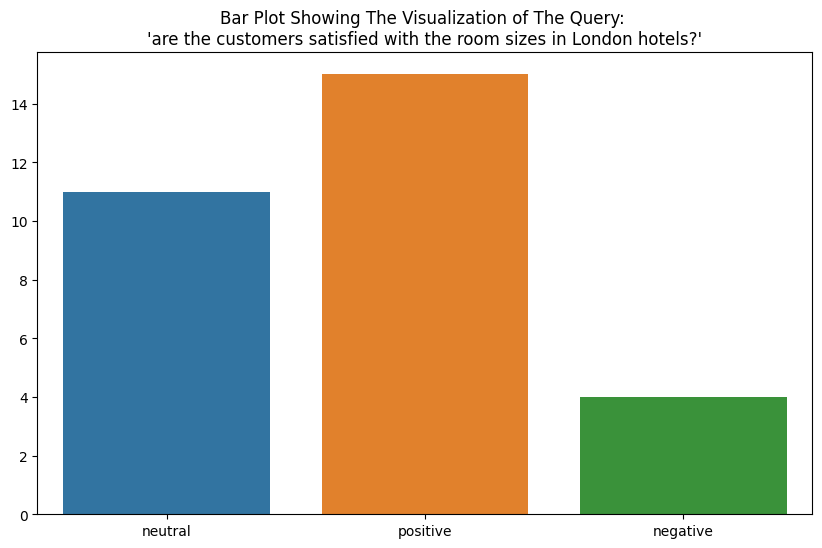

In [64]:
# Visualize the data.

import seaborn as sns


plt.figure(figsize=(10, 6))
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))
plt.title(f"Bar Plot Showing The Visualization of The Query: \n{query!r}")
plt.show()

#### Comment

- The customers are generally satisfied with the room sizes, although many are still neutral and negative.

<br>

### More Analysis

- We can be even more specific when searching for reviews with the help of Pinecone's metadata filtering.
- For instance, we can specify a period in our query to ensure that search results only contain customer reviews for that period.
- This is helpful if you want to understand the customer's opinion during a specific period.

- Let's do this for the same query as before. We will filter reviews from 25th December to 31st December 2015.
- Previously we added the review_date field as a timestamp to the metadata during indexing.
- We can convert the start and end date of the period to timestamp using the get_timestamp function and use a `$gte` (greater than or equal to) and a `$lte` (less than or equal to) filter to get reviews from only the selected period.

In [69]:
# Generate timestamps for start and end time of the period
s_date, e_date = ["2015-12-25", "2015-12-31"]
start_time: float = get_timestamp([s_date])[0]
end_time: float = get_timestamp([e_date])[0]

query: str = "are the customers satisified with the room sizes of hotels in London?"
# Generate query embeddings
enc_query: list[float] = retriever.encode(query).tolist()

# Query pinecone with query embeddings and the period filter
result = index.query(
    enc_query,
    top_k=N,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})

# Get an overall count of customer sentiment
sentiment = count_sentiment(result)


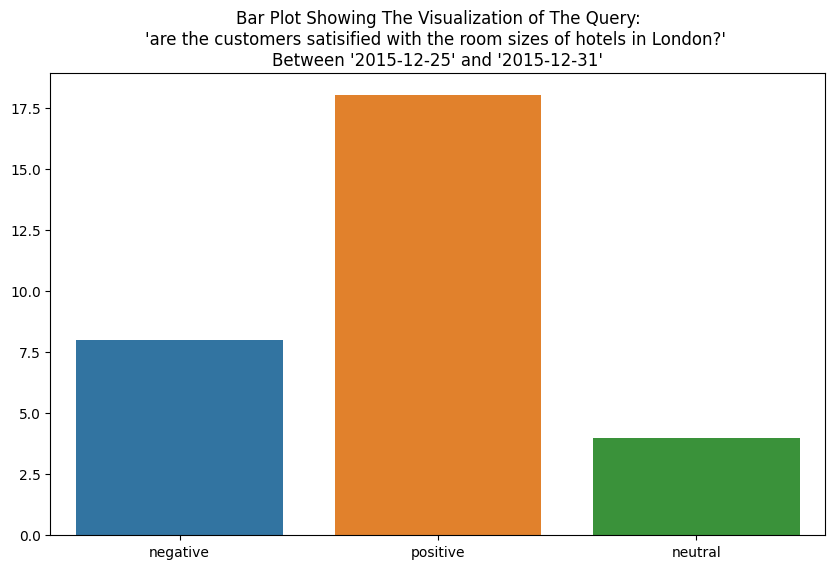

In [72]:
# plot a barchart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))
text: str = ("Bar Plot Showing The Visualization of The Query:"
 + f"\n{query!r} \nBetween {s_date!r} and {e_date!r}")
plt.title(text)
plt.show()

In [82]:
df_pl.select(pl.col("hotel_name")).unique().to_series().to_list()

['DoubleTree by Hilton London Docklands Riverside',
 'Park Plaza Westminster Bridge London',
 'Millennium Gloucester Hotel London',
 'Intercontinental London The O2',
 'Hotel Da Vinci',
 'DoubleTree by Hilton Hotel London Tower of London',
 'Britannia International Hotel Canary Wharf',
 'Park Plaza London Riverbank',
 'Park Grand Paddington Court',
 'Park Grand London Kensington',
 'St James Court A Taj Hotel London',
 'Copthorne Tara Hotel London Kensington',
 'Strand Palace Hotel',
 'Hilton London Metropole',
 'Holiday Inn London Kensington',
 'M by Montcalm Shoreditch London Tech City',
 'Hilton London Wembley',
 'Blakemore Hyde Park',
 'Park Plaza County Hall London',
 'Grand Royale London Hyde Park']

In [88]:
# Generate timestamps for start and end time of the period
s_date, e_date = ["2015-12-25", "2015-12-31"]
start_time: float = get_timestamp([s_date])[0]
end_time: float = get_timestamp([e_date])[0]

query: str = "are the customers satisified with the food in Hyde Park?"
# Generate query embeddings
enc_query: list[float] = retriever.encode(query).tolist()

# Query pinecone with query embeddings and the period filter
result = index.query(
    enc_query,
    top_k=N,
    include_metadata=True,
    filter={"timestamp": {"$gte": start_time, "$lte":end_time}})

# Get an overall count of customer sentiment
sentiment = count_sentiment(result)


In [89]:
result

{'matches': [{'id': '5846',
              'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
                           'label': 'positive',
                           'review': ' The place has a very good location '
                                     'surroundEd by many facilities and well '
                                     'communicated The breakfast if booked '
                                     'early is worth Just one complain they '
                                     'could have natural orange juice ',
                           'review_date': datetime.date(2015, 12, 29),
                           'review_length': 182.0,
                           'score': 0.9624735713005066,
                           'timestamp': 1451347200.0},
              'score': 0.550751388,
              'values': []},
             {'id': '5837',
              'metadata': {'hotel_name': 'Grand Royale London Hyde Park',
                           'label': 'positive',
                   

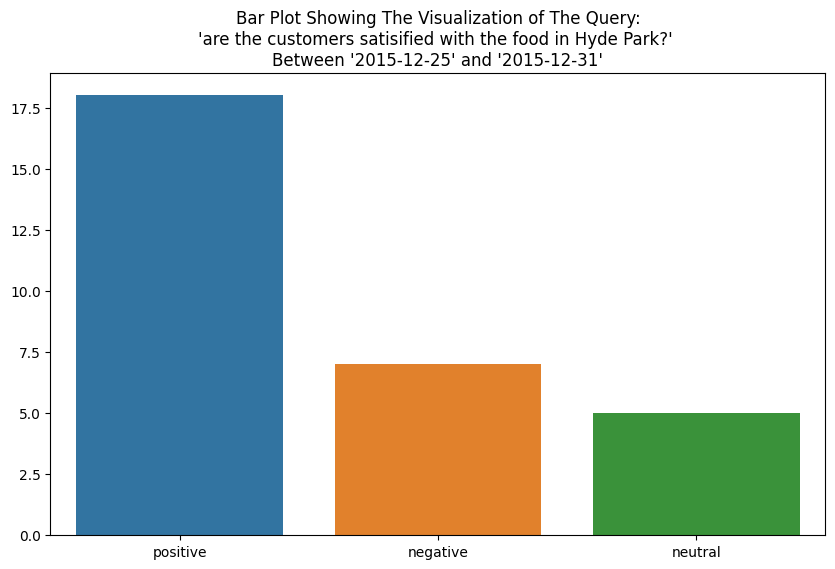

In [90]:
# plot a barchart using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=list(sentiment.keys()), y = list(sentiment.values()))
text: str = ("Bar Plot Showing The Visualization of The Query:"
 + f"\n{query!r} \nBetween {s_date!r} and {e_date!r}")
plt.title(text)
plt.show()

In [96]:
hotels: list[str] =[
    "Strand Palace Hotel",
    'Park Plaza County Hall London',
    'Grand Royale London Hyde Park',
    "Intercontinental London The O2",
]

### To Do

- We will look into five main areas:
  - Room Size
  - Cleanliness
  - Staff
  - Food
  - AC

- We have a query for each of these areas below.

In [91]:
queries = {
    "Room Size": "are customers happy with the room sizes?",
    "Cleanliness": "are customers satisfied with the cleanliness of the rooms?",
    "Staff": "did the customers like how they were treated by the staff?",
    "Food": "did the customers enjoy the food?",
    "AC": "customer opinion on the AC"
}

In [97]:
hotel_sentiments :list[Any] = []


# iterate through the hotels
for hotel in hotels:
    result = []
    # iterate through the keys and values in the queries dict
    for area, query in queries.items():
        # generate query embeddings
        xq = retriever.encode(query).tolist()
        # query pinecone with query embeddings and the hotel filter
        xc = index.query(xq, top_k=500, include_metadata=True, filter={"hotel_name": hotel})
        # get an overall count of customer sentiment
        sentiment = count_sentiment(xc)
        # sort the sentiment to show area and each value side by side
        for k, v in sentiment.items():
            data = {
                "area": area,
                "label": k,
                "value": v
            }
            # add the data to result list
            result.append(data)
    # convert the
    hotel_sentiments.append({"hotel": hotel, "df": pd.DataFrame(result)})

In [98]:
hotel_sentiments[0]["df"]

""
